In [1]:
from afinn import Afinn

In [2]:
texts = [
    "Elon Musk is a champion of free speech",
    "It's a terrible shame to see mashed potato thrown at art"
]

afinn = Afinn()
[afinn.score(t) for t in texts]

[3.0, -5.0]

In [3]:
afinn.score_with_wordlist(texts[0])

3.0

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

lex = pd.DataFrame(afinn._dict.items(),columns=["word","value"])
lex.head()

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [5]:
vec = CountVectorizer()
dfmat = vec.fit_transform(texts)
dfmat

<2x17 sparse matrix of type '<class 'numpy.int64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [6]:
import numpy as np

def tidy_dfmat(dfmat, vec):
    nz = dfmat.nonzero()
    text_df = pd.DataFrame({
        "document": np.array(texts)[nz[0]],
        "term": vec.get_feature_names_out()[nz[1]],
        "count": dfmat[nz].A1
    })
    return text_df
text_df = tidy_dfmat(dfmat, vec)
text_df.head()

,document,term,count
0,Elon Musk is a champion of free speech,elon,1
1,Elon Musk is a champion of free speech,musk,1
2,Elon Musk is a champion of free speech,is,1
3,Elon Musk is a champion of free speech,champion,1
4,Elon Musk is a champion of free speech,of,1


In [7]:
text_tokens = text_df.merge(lex, left_on="term", right_on="word")
text_tokens["value"] *= text_tokens["count"]
text_tokens

,document,term,count,word,value
0,Elon Musk is a champion of free speech,champion,1,champion,2
1,Elon Musk is a champion of free speech,free,1,free,1
2,It's a terrible shame to see mashed potato thr...,terrible,1,terrible,-3
3,It's a terrible shame to see mashed potato thr...,shame,1,shame,-2


In [8]:
doc_sentiments = text_tokens.groupby("document")["value"].sum()
doc_sentiments

document
Elon Musk is a champion of free speech                      3
It's a terrible shame to see mashed potato thrown at art   -5
Name: value, dtype: int64

In [9]:
with open("../datasets/YesScotlandTweets.csv", "r", encoding="unicode_escape") as f:
    with open("../datasets/YesScotlandTweets_cleaned.csv", "w") as out:
        for i,l in enumerate(f):
            l = l.strip('";\n').replace('""','"').replace('&amp";','&amp;').replace('&amp;"','&amp;').replace('";"','""')
            l = l.replace('&gt;"','&gt;').replace('&gt";','&gt;')
            out.write(l)
            out.write("\n")

In [10]:
with open("../datasets/UkTogetherTweets.csv", "r", encoding="unicode_escape") as f:
    with open("../datasets/UkTogetherTweets_cleaned.csv", "w") as out:
        for i,l in enumerate(f):
            l = l.strip('";\n').replace('""','"').replace('&amp";','&amp;').replace('&amp;"','&amp;').replace('";"','""')
            l = l.replace('&gt;"','&gt;').replace('&gt";','&gt;')
            out.write(l)
            out.write("\n")

In [11]:
yes = pd.read_csv("../datasets/YesScotlandTweets_cleaned.csv")
yes["campaign"] = "YesScotland"
no = pd.read_csv("../datasets/UkTogetherTweets_cleaned.csv")
no["campaign"] = "UkTogether"
df = pd.concat([yes, no]).reset_index(drop=True)

print(df.shape)
df.head()

(5933, 18)


,x,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude,campaign
0,1,"Thank you, everyone! #indyref http://t.co/1kTz...",False,1744,NaN,2014-09-18 21:01,False,NaN,5.130000e+17,NaN,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",YesScotland,2167,False,False,NaN,NaN,YesScotland
1,2,"As the polls close, total likes on the @YesSco...",False,540,NaN,2014-09-18 20:57,False,NaN,5.130000e+17,NaN,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",YesScotland,449,False,False,NaN,NaN,YesScotland
2,3,RT @YESforScotland4: #voteyes YES what a fanta...,False,0,NaN,2014-09-18 20:51,False,NaN,5.130000e+17,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",YesScotland,121,True,False,NaN,NaN,YesScotland
3,4,"We can be proud of #indyref, which has seen a ...",False,576,NaN,2014-09-18 20:45,False,NaN,5.130000e+17,NaN,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",YesScotland,669,False,False,NaN,NaN,YesScotland
4,5,RT @Crafty_Goddess: Txt from 25 year old niece...,False,0,NaN,2014-09-18 20:41,False,NaN,5.130000e+17,NaN,"<a href=""http://www.hootsuite.com"" rel=""nofoll...",YesScotland,130,True,False,NaN,NaN,YesScotland


In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

results = [analyzer.polarity_scores(x) for x in df["text"]]
sentiment = pd.DataFrame.from_dict(results)

sentiment_df = pd.concat([df,sentiment], axis=1)
sentiment_df.head()

,x,text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,...,retweetCount,isRetweet,retweeted,longitude,latitude,campaign,neg,neu,pos,compound
0,1,"Thank you, everyone! #indyref http://t.co/1kTz...",False,1744,NaN,2014-09-18 21:01,False,NaN,5.130000e+17,NaN,...,2167,False,False,NaN,NaN,YesScotland,0.000,0.589,0.411,0.4199
1,2,"As the polls close, total likes on the @YesSco...",False,540,NaN,2014-09-18 20:57,False,NaN,5.130000e+17,NaN,...,449,False,False,NaN,NaN,YesScotland,0.000,0.853,0.147,0.4754
2,3,RT @YESforScotland4: #voteyes YES what a fanta...,False,0,NaN,2014-09-18 20:51,False,NaN,5.130000e+17,NaN,...,121,True,False,NaN,NaN,YesScotland,0.000,0.703,0.297,0.8668
3,4,"We can be proud of #indyref, which has seen a ...",False,576,NaN,2014-09-18 20:45,False,NaN,5.130000e+17,NaN,...,669,False,False,NaN,NaN,YesScotland,0.000,0.853,0.147,0.4767
4,5,RT @Crafty_Goddess: Txt from 25 year old niece...,False,0,NaN,2014-09-18 20:41,False,NaN,5.130000e+17,NaN,...,130,True,False,NaN,NaN,YesScotland,0.055,0.823,0.122,0.4497


In [13]:
sentiment_df.sort_values("compound").head()[["text","compound"]].values

array([['A statement: There is ABSOLUTELY no place for attacks - be they abuse, graffiti, vandalism or physical assault - in this campaign. #indyref',
        -0.934],
       ['Westminster wants to waste our resources on renewing obscene and dangerous weapons of mass destruction. Scotland can do better. #indyref',
        -0.9246],
       ['.@TogetherAlistairDarling - "The nationalist threat to default on our debt is irresponsible and reckless." http://t.co/xQSWYauTgg',
        -0.8885],
       ['RT @AlexSalmond: The murder of David Haines shows a degree of brutality which defies description. Thoughts &amp; prayers with his family http:/\x8a\x97_',
        -0.8658],
       ['Salmond warned that reckless threat to default on debt could lead to higher mortgage payments for Scots http://t.co/2Nmk95diKP #indyref',
        -0.8658]], dtype=object)

In [14]:
sentiment_df.sort_values("compound", ascending=False).head()[["text","compound"]].values

array([['RT @dobbs_michael: Off to Edinburgh. Yesterday great campaigning in W Scotland, smiles, great support. Hope to find many more proud Scots t\x8a\x97_',
        0.9652],
       ['A Yes means greater financial security for families - we can expand free childcare, safeguard free education and create more jobs. #indyref',
        0.9595],
       ['RT @mstewart_23: #indyref is about the country we want to live in &amp; how best to create that. YES gives us the best opportunity to do that. \x8a\x97_',
        0.9519],
       ["With Yes, we can build on Scotland's successes in delivering for older people, such as free personal care and the free bus pass. #indyref",
        0.9442],
       ["With a Yes, we can make Scotland's wealth work better for our families - with better jobs and increased free childcare. #indyref #VoteYes",
        0.9442]], dtype=object)

In [87]:
sentiment_df["date"] = pd.to_datetime(df.created).dt.date
daily_sentiment = (sentiment_df
                   .groupby(["date","campaign"])["compound"]
                   .mean()
                   .reset_index()
                   .pivot_table(columns="campaign", values="compound", index="date")
                   .reset_index()
                  )

daily_sentiment["date"] = pd.to_datetime(daily_sentiment["date"])
days = pd.date_range(start="2014-06-01",end="2014-09-18")
daily_sentiment = pd.DataFrame({"date": days}).merge(daily_sentiment, how="left")
daily_sentiment

,date,UkTogether,YesScotland
0,2014-06-01,0.647000,NaN
1,2014-06-02,0.228642,NaN
2,2014-06-03,0.174267,NaN
3,2014-06-04,0.209287,NaN
4,2014-06-05,0.202725,NaN
...,...,...,...
105,2014-09-14,0.301605,0.449876
106,2014-09-15,0.345212,0.416044
107,2014-09-16,0.056021,0.405935
108,2014-09-17,0.516338,0.344746


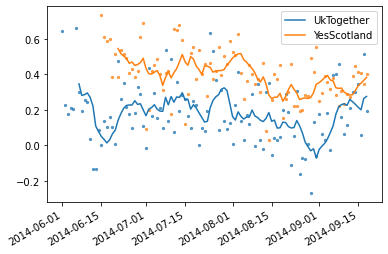

In [88]:
fig, ax = plt.subplots()

for campaign in ["UkTogether", "YesScotland"]:
    ax.scatter(daily_sentiment.date, daily_sentiment[campaign], s=5, alpha=0.7)
    x = daily_sentiment[campaign].rolling(7).mean()
    ax.plot(daily_sentiment.date, x, label=campaign)

fig.autofmt_xdate()
ax.legend()